In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import urllib
import imgaug.augmenters as iaa
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split


**Indian Driving Dataset**
*   I chose the IDD as it captures the uniqueness of the Indian driving scene. It includes various types of road conditions, traffic situations, and typical elements found on Indian roads such as animals, auto-rickshaws etc.
*   The dataset consists of images  obtained from a front facing camera  attached to a car and their annotations. The car was driven around Hyderabad, Bangalore  cities and their outskirts.
*   This implementation contains 21 unique classes in annotations.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_dir='/content/drive/MyDrive/data2/images'
import os

In [ ]:
data_df=pd.read_csv('/content/drive/MyDrive/data_df.csv')

In [ ]:
image_list=[]
for i in sorted(os.listdir(image_dir)):
  image_list.append(os.path.join(image_dir,i))

In [ ]:
data_df.head()

image  \
0  /content/drive/MyDrive/data2/images/000035_lef...   
1  /content/drive/MyDrive/data2/images/000065_lef...   
2  /content/drive/MyDrive/data2/images/000128_lef...   
3  /content/drive/MyDrive/data2/images/000175_lef...   
4  /content/drive/MyDrive/data2/images/000179_lef...   

                                                json  \
0  /content/drive/MyDrive/data2/mask/000035_gtFin...   
1  /content/drive/MyDrive/data2/mask/000065_gtFin...   
2  /content/drive/MyDrive/data2/mask/000128_gtFin...   
3  /content/drive/MyDrive/data2/mask/000175_gtFin...   
4  /content/drive/MyDrive/data2/mask/000179_gtFin...   

                                                mask  
0  /content/drive/MyDrive/data2/output/000035_gtF...  
1  /content/drive/MyDrive/data2/output/000065_gtF...  
2  /content/drive/MyDrive/data2/output/000128_gtF...  
3  /content/drive/MyDrive/data2/output/000175_gtF...  
4  /content/drive/MyDrive/data2/output/000179_gtF...

In [ ]:
mask_dir='/content/drive/MyDrive/data2/mask'

In [ ]:
mask_list=[]
for i in sorted(os.listdir(mask_dir)):
  mask_list.append(os.path.join(mask_dir,i))

In [ ]:
import pandas as pd
data_df= pd.DataFrame(columns=['image','json'])

In [ ]:
data_df['image']=image_list
data_df['json']=mask_list

In [ ]:
data_df.shape

(7859, 2)

In [ ]:
data_df.head()

image  \
0  /content/drive/MyDrive/data2/images/000035_lef...   
1  /content/drive/MyDrive/data2/images/000065_lef...   
2  /content/drive/MyDrive/data2/images/000128_lef...   
3  /content/drive/MyDrive/data2/images/000175_lef...   
4  /content/drive/MyDrive/data2/images/000179_lef...   

                                                json  
0  /content/drive/MyDrive/data2/mask/000035_gtFin...  
1  /content/drive/MyDrive/data2/mask/000065_gtFin...  
2  /content/drive/MyDrive/data2/mask/000128_gtFin...  
3  /content/drive/MyDrive/data2/mask/000175_gtFin...  
4  /content/drive/MyDrive/data2/mask/000179_gtFin...

Checking how many unique labels are present in the json files

In [ ]:
import json
from tqdm.auto import tqdm
a=[dir]
def return_unique_labels(data_df):

    for i in tqdm(data_df['json']):
      f = open(i,)
      data =json.load(f)
      for j in data['objects']:
        a.append((j.get('label')))
    return a

In [ ]:
unique_labels = return_unique_labels(data_df)

  0%|          | 0/7859 [00:00<?, ?it/s]

In [ ]:
def unique(list1):
    list_set = set(list1)
    unique_list = (list(list_set))
    return unique_list
unique_labels=unique(unique_labels)

In [ ]:
len(unique_labels)

40

In [ ]:
(unique_labels)

['truck',
 'polegroup',
 'person',
 'billboard',
 'ego vehicle',
 'bridge',
 'fence',
 'building',
 'vegetation',
 'curb',
 'license plate',
 'rectification border',
 'sidewalk',
 'rail track',
 'autorickshaw',
 'pole',
 'traffic sign',
 'tunnel',
 'trailer',
 'motorcycle',
 'sky',
 'guard rail',
 'animal',
 'bicycle',
 'rider',
 'obs-str-bar-fallback',
 'caravan',
 'fallback background',
 <function dir>,
 'non-drivable fallback',
 'parking',
 'traffic light',
 'drivable fallback',
 'train',
 'vehicle fallback',
 'bus',
 'out of roi',
 'wall',
 'car',
 'road']

In [ ]:
unique_labels.remove(unique_labels[26])

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\

            'out of roi':0, 'ego vehicle':170, 'license plate':80, 'ground':180,'rectification border':190,\
                   'train':200}

Extracting polygons from json files

In [ ]:
def get_poly(file):
    f = open(file,)
    data = json.load(f)
    label,vertexlist=[],[]
    for obj in data['objects']:
        label.append(obj['label'])
        vertexlist.append([tuple(vertex) for vertex in obj['polygon']])
    w= data['imgWidth']
    h=data['imgHeight']
    return w, h, label, vertexlist

In [ ]:
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import numpy as np

Generating annotation masks from json files by filling polygons with intensity value as per label_clr dictionary

In [ ]:
def compute_masks(data_df):
    mask=[]
    for file in tqdm(data_df['json']):
        w, h, labels, vertexlist = get_poly(file)

        img= Image.new("RGB",(w,h))
        img1 = ImageDraw.Draw(img)
        for i in range(len(labels)):
            if(len(vertexlist[i])>1):
                img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        new_file=file.replace('mask','output')
        new_file=new_file.replace('json','png')
        os.makedirs('data/output/'+file.split('/')[2],exist_ok=True)
        im.save(new_file)
        mask.append(new_file)
    data_df['mask']=mask

    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

  0%|          | 0/7859 [00:00<?, ?it/s]

image  \
0  /content/drive/MyDrive/data2/images/000035_lef...   
1  /content/drive/MyDrive/data2/images/000065_lef...   
2  /content/drive/MyDrive/data2/images/000128_lef...   
3  /content/drive/MyDrive/data2/images/000175_lef...   
4  /content/drive/MyDrive/data2/images/000179_lef...   

                                                json  \
0  /content/drive/MyDrive/data2/mask/000035_gtFin...   
1  /content/drive/MyDrive/data2/mask/000065_gtFin...   
2  /content/drive/MyDrive/data2/mask/000128_gtFin...   
3  /content/drive/MyDrive/data2/mask/000175_gtFin...   
4  /content/drive/MyDrive/data2/mask/000179_gtFin...   

                                                mask  
0  /content/drive/MyDrive/data2/output/000035_gtF...  
1  /content/drive/MyDrive/data2/output/000065_gtF...  
2  /content/drive/MyDrive/data2/output/000128_gtF...  
3  /content/drive/MyDrive/data2/output/000175_gtF...  
4  /content/drive/MyDrive/data2/output/000179_gtF...

Visualising the data

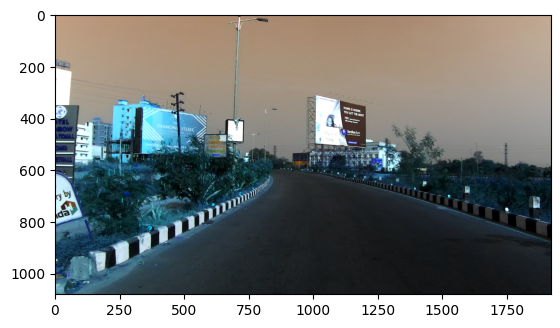

In [18]:
img=cv2.imread('/content/drive/MyDrive/data2/images/000263_leftImg8bit.png')
plt.imshow(img)

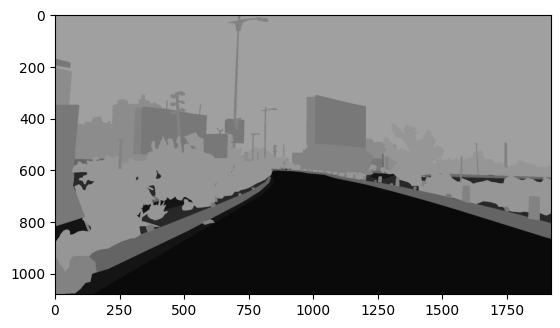

In [19]:
mask=cv2.imread('/content/drive/MyDrive/data2/output/000263_gtFine_polygons.png')
plt.imshow(mask)

In [ ]:
data_df.to_csv('/content/drive/MyDrive/data_df.csv',index=False)

In [ ]:
import joblib
joblib.dump(data_df,'data.pkl')

['data.pkl']

In [ ]:
import joblib
data_df = joblib.load('data.pkl')

In [ ]:
import urllib.request

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

Unet Architecture


1.   Encoder path- 4 encoder blocks each with 2 convolutional layers followed by 1 max pooling layer.
2.   Bottle neck- 2 convolutional layers to further extract feautures from encoder output without down sampling.
3. Decoder path  - 4 decoder blocks each with a transpose convolutional layer for upsampling followed by concatenation of convolutional outputs from corresponding encoder blocks (skip connections) and 2 covolutional layers.
Final predictions are obtained by applying softmax activation on output of 1x1 convolution with 21 filters

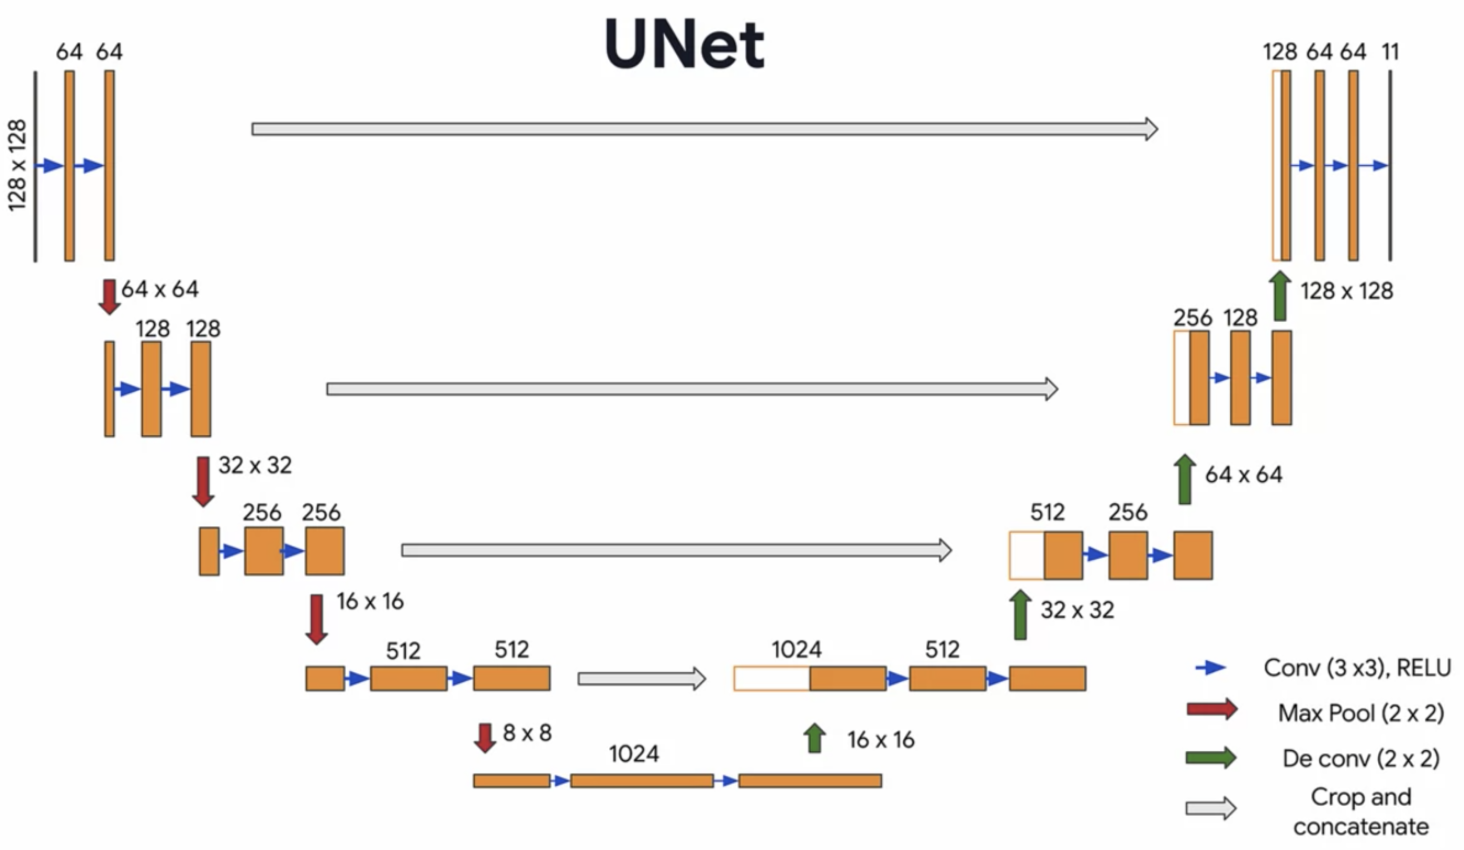

**Encoder Utilities**

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  return x
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
  p = tf.keras.layers.Dropout(0.3)(p)
  return f, p
def encoder(inputs):
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)
  return p4, (f1, f2, f3, f4)

**Bottle Neck**

In [ ]:
def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs, n_filters=1024)
  return bottle_neck

**Decoder Utilities**

In [ ]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):

  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):


  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)
  #outputs=tf.keras.layers.Flatten()(outputs)
  #outputs=tf.squeeze(outputs)

  return outputs



In [ ]:
OUTPUT_CHANNELS = 21

def unet():

  inputs = tf.keras.layers.Input(shape=(256,256,3))
  encoder_output, convs = encoder(inputs)
  bottle_neck = bottleneck(encoder_output)
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(data_df, test_size=0.11, random_state=42)

image augmentation utilities to prevent over fitting

In [ ]:
import imgaug.augmenters as iaa
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()


class Dataset:

    def __init__(self , basepath , images_file_names , mask_file_names , CLASSES):

        self.image_ids = images_file_names
        self.mask_ids = mask_file_names
        self.images_fps   = [os.path.join(basepath,image_id) for image_id in self.image_ids]
        self.masks_fps    = [os.path.join(basepath,mask_id) for mask_id in self.mask_ids]
        self.CLASSES= CLASSES
        self.class_values = CLASSES

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(mask,(256,256))
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        if self.images_fps[i] in x_train:
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask
          else:
              image = aug6.augment_image(image)
              image_mask = aug6.augment_image(image_mask)

        return image, image_mask

    def __len__(self):
        return len(self.image_ids)


class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
CLASSES = list(np.unique(list(label_clr.values())))

In [ ]:
print(len(CLASSES))

21


In [ ]:
from keras.callbacks import Callback, ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from keras.callbacks import TensorBoard
import time
# import datetime
!rm -rf '/content/logs'
CLASSES = CLASSES
basepath = '/content/'
train_dataset = Dataset(basepath, x_train['image'].values, x_train['mask'].values, CLASSES=CLASSES)
test_dataset = Dataset(basepath, x_test['image'].values, x_test['mask'].values, CLASSES=CLASSES)
train_dataloader = Dataloder(train_dataset, batch_size=32, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=32, shuffle=True)
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
file_path='/content/drive/MyDrive/unet1.ckpt'
checkpoint = ModelCheckpoint(filepath=file_path, save_weights_only=True,save_best_only=True, mode='max', monitor='val_accuracy')
callback_list=[checkpoint]


(32, 256, 256, 3)
(32, 256, 256, 21)


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=1,\
                              validation_data=test_dataloader,callbacks=callback_list)

148/218 [===================>..........] - ETA: 3:34 - loss: 1.1226 - accuracy: 0.6544

KeyboardInterrupt: 

In [ ]:
model.load_weights('/content/drive/MyDrive/unet1.ckpt')

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=    2, IoU=0.000
class 01: #TP= 14147, #FP=   398, #FN= 1528, IoU=0.880
class 02: #TP=     0, #FP=   407, #FN=    0, IoU=0.000
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=     0, #FP=     6, #FN=    0, IoU=0.000
class 05: #TP=     0, #FP=    30, #FN=   17, IoU=0.000
class 06: #TP=    22, #FP=    97, #FN= 2451, IoU=0.009
class 07: #TP=    55, #FP=    93, #FN= 1659, IoU=0.030
class 08: #TP=  2338, #FP=  5243, #FN= 2444, IoU=0.233
class 09: #TP=  1524, #FP=  2174, #FN= 3204, IoU=0.221
class 10: #TP=     0, #FP=   154, #FN=   41, IoU=0.000
class 11: #TP=     0, #FP=     8, #FN=   99, IoU=0.000
class 12: #TP=     5, #FP=     2, #FN= 5600, IoU=0.001
class 13: #TP=     8, #FP=   174, #FN= 2199, IoU=0.003
class 14: #TP=   791, #FP=  9441, #FN=  168, IoU=0.076
class 15: #TP=  1269, #FP=  3688, #FN=   88, IoU=0.252
class 16: #TP= 23409, #FP=    53, #FN= 2468, IoU=0.903


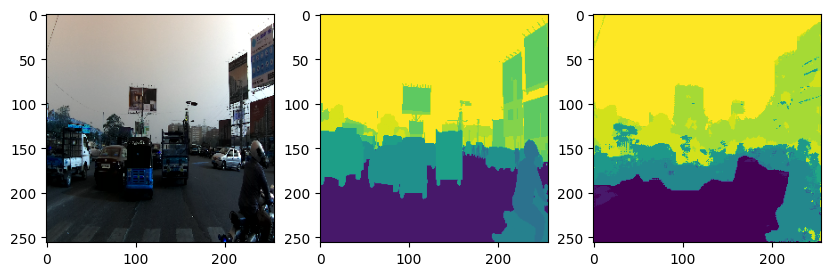

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=    1, IoU=0.000
class 01: #TP= 12689, #FP=  6033, #FN=  396, IoU=0.664
class 02: #TP=     9, #FP=   939, #FN= 1359, IoU=0.004
class 03: #TP=     0, #FP=     0, #FN= 5992, IoU=0.000
class 04: #TP=     0, #FP=   135, #FN=    0, IoU=0.000
class 05: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 06: #TP=     3, #FP=    28, #FN=  125, IoU=0.019
class 07: #TP=    19, #FP=    20, #FN=   52, IoU=0.209
class 08: #TP=  4849, #FP=  2048, #FN= 1147, IoU=0.603
class 09: #TP=     0, #FP=  5287, #FN=  102, IoU=0.000
class 10: #TP=   170, #FP=   183, #FN=21478, IoU=0.008
class 11: #TP=     0, #FP=     0, #FN=  718, IoU=0.000
class 12: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 13: #TP=    49, #FP=   234, #FN=  191, IoU=0.103
class 14: #TP=   395, #FP= 14672, #FN=  128, IoU=0.026
class 15: #TP=  7737, #FP=  3545, #FN= 1661, IoU=0.598
class 16: #TP=  5858, #FP=   634, #FN=  408, IoU=0.849


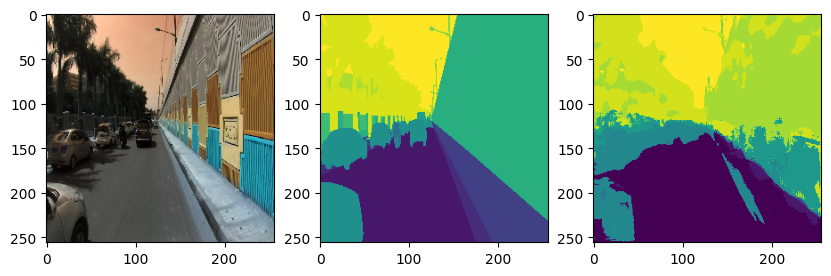

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=   19, IoU=0.000
class 01: #TP= 19886, #FP=   584, #FN= 2754, IoU=0.856
class 02: #TP=   773, #FP=   272, #FN= 1110, IoU=0.359
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=     0, #FP=     8, #FN=  747, IoU=0.000
class 05: #TP=     0, #FP=    15, #FN= 2776, IoU=0.000
class 06: #TP=     5, #FP=   108, #FN=   81, IoU=0.026
class 07: #TP=    20, #FP=    53, #FN=  571, IoU=0.031
class 08: #TP=   771, #FP=  5237, #FN=  926, IoU=0.111
class 09: #TP=   232, #FP=  4150, #FN=  467, IoU=0.048
class 10: #TP=    45, #FP=   501, #FN= 1703, IoU=0.020
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=     0, #FP=     2, #FN= 1820, IoU=0.000
class 13: #TP=   104, #FP=   145, #FN= 3627, IoU=0.027
class 14: #TP=  6285, #FP=  4114, #FN= 2232, IoU=0.498
class 15: #TP=  4272, #FP=  4409, #FN=  402, IoU=0.470
class 16: #TP= 13181, #FP=   364, #FN=  727, IoU=0.924


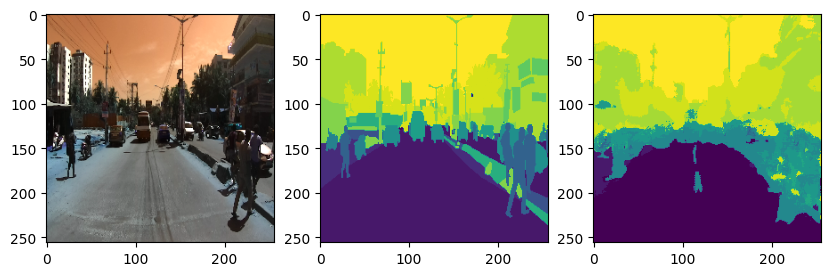

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=   27, IoU=0.000
class 01: #TP= 22903, #FP=  1983, #FN=  818, IoU=0.891
class 02: #TP=     0, #FP=  3958, #FN=    0, IoU=0.000
class 03: #TP=     0, #FP=     0, #FN= 6181, IoU=0.000
class 04: #TP=     0, #FP=    54, #FN=   17, IoU=0.000
class 05: #TP=     0, #FP=     0, #FN=  116, IoU=0.000
class 06: #TP=     6, #FP=     0, #FN= 1016, IoU=0.006
class 07: #TP=    31, #FP=    25, #FN=  803, IoU=0.036
class 08: #TP=    49, #FP=  4613, #FN=   47, IoU=0.010
class 09: #TP=    25, #FP=  2529, #FN=  395, IoU=0.008
class 10: #TP=   692, #FP=  2340, #FN= 6224, IoU=0.075
class 11: #TP=     0, #FP=     0, #FN= 2000, IoU=0.000
class 12: #TP=     0, #FP=     0, #FN=  419, IoU=0.000
class 13: #TP=    37, #FP=    34, #FN= 3235, IoU=0.011
class 14: #TP=   119, #FP=  3474, #FN=    5, IoU=0.033
class 15: #TP=  9398, #FP=  3596, #FN= 1053, IoU=0.669
class 16: #TP=  9562, #FP=   108, #FN=  358, IoU=0.954


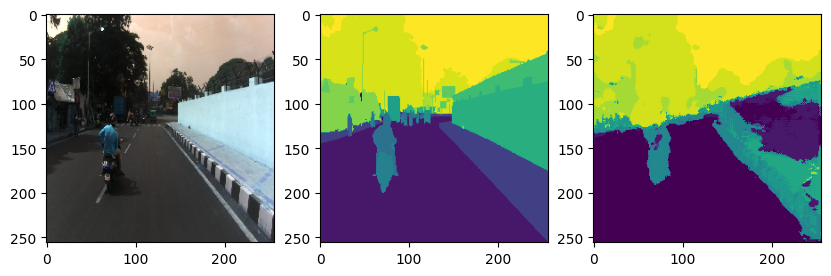

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=    1, IoU=0.000
class 01: #TP= 21659, #FP=   892, #FN= 1161, IoU=0.913
class 02: #TP=     3, #FP=   254, #FN= 1088, IoU=0.002
class 03: #TP=     0, #FP=     0, #FN= 2850, IoU=0.000
class 04: #TP=     0, #FP=    10, #FN=    0, IoU=0.000
class 05: #TP=     0, #FP=     0, #FN=  485, IoU=0.000
class 06: #TP=     5, #FP=    13, #FN=  170, IoU=0.027
class 07: #TP=    59, #FP=    10, #FN=  639, IoU=0.083
class 08: #TP=  2276, #FP=  6345, #FN=  230, IoU=0.257
class 09: #TP=  1702, #FP=  3175, #FN= 4944, IoU=0.173
class 10: #TP=   311, #FP=  1288, #FN= 4238, IoU=0.053
class 11: #TP=     0, #FP=     0, #FN= 1653, IoU=0.000
class 12: #TP=     0, #FP=     0, #FN=   82, IoU=0.000
class 13: #TP=   110, #FP=   348, #FN= 2476, IoU=0.037
class 14: #TP=   638, #FP=  4750, #FN= 1324, IoU=0.095
class 15: #TP= 10435, #FP=  3620, #FN=  319, IoU=0.726
class 16: #TP=  6565, #FP=  1068, #FN=  113, IoU=0.848


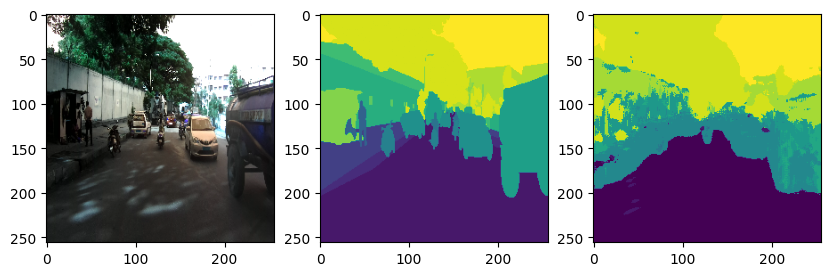

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=  117, IoU=0.000
class 01: #TP= 14382, #FP=  3796, #FN= 1501, IoU=0.731
class 02: #TP=   597, #FP=   575, #FN= 1179, IoU=0.254
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=     0, #FP=   138, #FN=    0, IoU=0.000
class 05: #TP=     0, #FP=     1, #FN=  369, IoU=0.000
class 06: #TP=     2, #FP=    31, #FN= 1014, IoU=0.002
class 07: #TP=    52, #FP=    58, #FN=  973, IoU=0.048
class 08: #TP=   211, #FP=  5995, #FN=  152, IoU=0.033
class 09: #TP=  1128, #FP=  3983, #FN= 1417, IoU=0.173
class 10: #TP=     0, #FP=  3667, #FN=    0, IoU=0.000
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=     0, #FP=     0, #FN=  276, IoU=0.000
class 13: #TP=    83, #FP=   153, #FN=15859, IoU=0.005
class 14: #TP=   628, #FP=  3659, #FN= 1186, IoU=0.115
class 15: #TP= 14953, #FP=  3382, #FN=  860, IoU=0.779
class 16: #TP=  7929, #FP=   133, #FN=  668, IoU=0.908


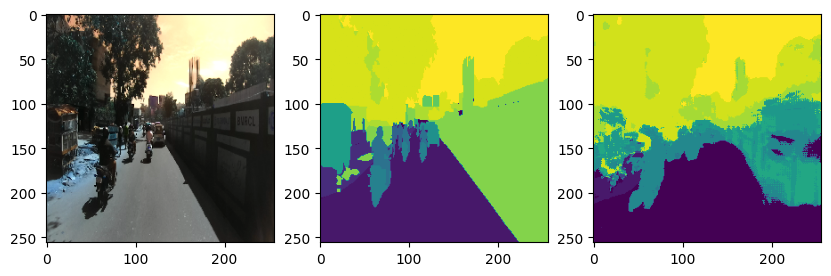

1/1 [==============================] - 3s 3s/step
class 00: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 01: #TP= 21299, #FP=   533, #FN= 1422, IoU=0.916
class 02: #TP=   122, #FP=   304, #FN=  425, IoU=0.143
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=     0, #FP=    40, #FN=    1, IoU=0.000
class 05: #TP=     0, #FP=     5, #FN=  309, IoU=0.000
class 06: #TP=    46, #FP=   137, #FN= 1815, IoU=0.023
class 07: #TP=   149, #FP=   118, #FN= 2206, IoU=0.060
class 08: #TP=  3102, #FP=  4972, #FN= 3480, IoU=0.268
class 09: #TP=     0, #FP=  5902, #FN=    0, IoU=0.000
class 10: #TP=    49, #FP=   610, #FN=  533, IoU=0.041
class 11: #TP=     0, #FP=     0, #FN=  246, IoU=0.000
class 12: #TP=     2, #FP=    17, #FN=  220, IoU=0.008
class 13: #TP=    61, #FP=   465, #FN= 1374, IoU=0.032
class 14: #TP=  6159, #FP=  1088, #FN= 4875, IoU=0.508
class 15: #TP= 15112, #FP=  4157, #FN= 1369, IoU=0.732
class 16: #TP=   865, #FP=   222, #FN=  295, IoU=0.626


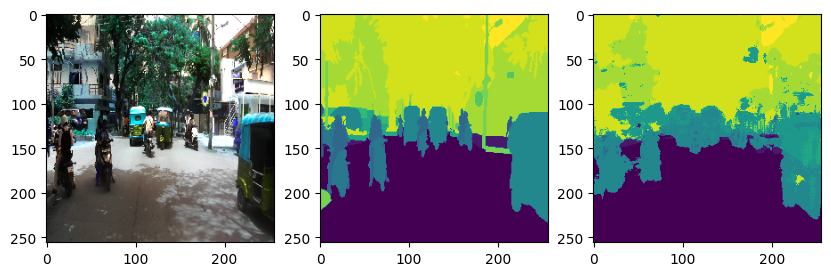

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=    3, IoU=0.000
class 01: #TP= 23976, #FP=   469, #FN=  222, IoU=0.972
class 02: #TP=   633, #FP=  1249, #FN=  486, IoU=0.267
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=   319, #FP=   320, #FN= 3945, IoU=0.070
class 05: #TP=     0, #FP=     0, #FN=   34, IoU=0.000
class 06: #TP=     2, #FP=     1, #FN=   30, IoU=0.061
class 07: #TP=    10, #FP=   236, #FN=   36, IoU=0.035
class 08: #TP=    13, #FP=  1711, #FN=   39, IoU=0.007
class 09: #TP=   409, #FP=  2186, #FN= 1315, IoU=0.105
class 10: #TP=   342, #FP=   895, #FN= 1964, IoU=0.107
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=     0, #FP=    15, #FN=   39, IoU=0.000
class 13: #TP=    78, #FP=   588, #FN= 2885, IoU=0.022
class 14: #TP=     7, #FP=  1627, #FN=  352, IoU=0.004
class 15: #TP= 13678, #FP=  2647, #FN=  605, IoU=0.808
class 16: #TP= 13827, #FP=   298, #FN=  287, IoU=0.959


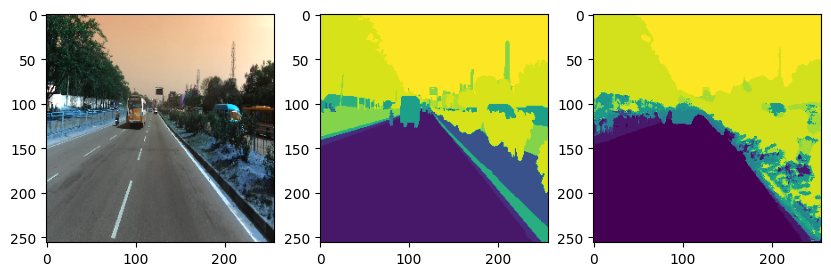

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=    5, IoU=0.000
class 01: #TP= 28273, #FP=  1455, #FN=  726, IoU=0.928
class 02: #TP=   273, #FP=   151, #FN=  810, IoU=0.221
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=     0, #FP=     2, #FN= 1372, IoU=0.000
class 05: #TP=     0, #FP=     1, #FN=    0, IoU=0.000
class 06: #TP=     0, #FP=    11, #FN=  460, IoU=0.000
class 07: #TP=    48, #FP=    28, #FN=  436, IoU=0.094
class 08: #TP=   124, #FP=  2118, #FN=  248, IoU=0.050
class 09: #TP=     0, #FP=   654, #FN=    0, IoU=0.000
class 10: #TP=   228, #FP=   396, #FN= 1015, IoU=0.139
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 13: #TP=     0, #FP=    66, #FN=  782, IoU=0.000
class 14: #TP=     0, #FP=   931, #FN=    0, IoU=0.000
class 15: #TP= 27288, #FP=  1910, #FN= 1517, IoU=0.888
class 16: #TP=  1504, #FP=    75, #FN=  427, IoU=0.750


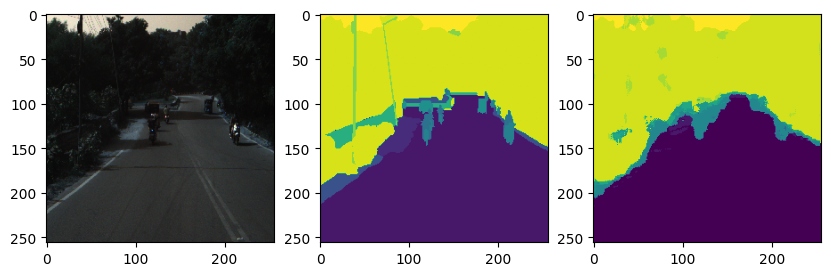

1/1 [==============================] - 3s 3s/step
class 00: #TP=     0, #FP=     0, #FN=    2, IoU=0.000
class 01: #TP= 18238, #FP=  1121, #FN=  505, IoU=0.918
class 02: #TP=     0, #FP=   128, #FN=    0, IoU=0.000
class 03: #TP=     0, #FP=     0, #FN= 3355, IoU=0.000
class 04: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 05: #TP=     0, #FP=     5, #FN=   31, IoU=0.000
class 06: #TP=     0, #FP=    21, #FN= 1565, IoU=0.000
class 07: #TP=    10, #FP=    17, #FN= 1846, IoU=0.005
class 08: #TP=  3872, #FP=  5493, #FN= 1092, IoU=0.370
class 09: #TP=   557, #FP=  4964, #FN=  407, IoU=0.094
class 10: #TP=   691, #FP=  1080, #FN= 4048, IoU=0.119
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=     0, #FP=     2, #FN= 1269, IoU=0.000
class 13: #TP=     3, #FP=    85, #FN=  917, IoU=0.003
class 14: #TP=   224, #FP=  1842, #FN=  404, IoU=0.091
class 15: #TP= 16886, #FP=  1727, #FN= 1252, IoU=0.850
class 16: #TP=  8271, #FP=   299, #FN=   91, IoU=0.955


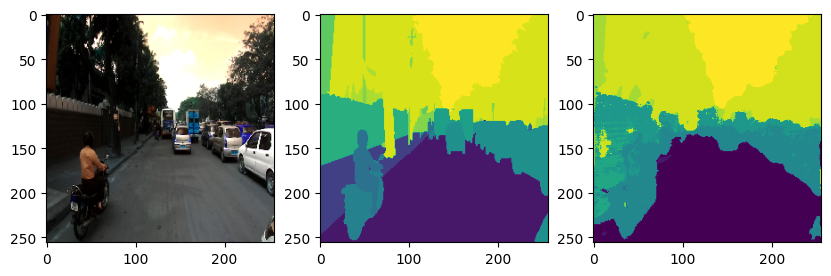

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=   12, IoU=0.000
class 01: #TP= 12564, #FP=  2528, #FN= 2312, IoU=0.722
class 02: #TP=  1442, #FP=   952, #FN= 2001, IoU=0.328
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=     0, #FP=    89, #FN= 1796, IoU=0.000
class 05: #TP=     0, #FP=     0, #FN=  246, IoU=0.000
class 06: #TP=     4, #FP=    13, #FN= 1590, IoU=0.002
class 07: #TP=     2, #FP=     6, #FN=  332, IoU=0.006
class 08: #TP=  1925, #FP=  5653, #FN=  626, IoU=0.235
class 09: #TP=     4, #FP=  5197, #FN=   15, IoU=0.001
class 10: #TP=   397, #FP=   261, #FN= 2092, IoU=0.144
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=     0, #FP=     7, #FN= 3325, IoU=0.000
class 13: #TP=    35, #FP=   170, #FN= 2283, IoU=0.014
class 14: #TP=  8209, #FP=  4591, #FN= 4892, IoU=0.464
class 15: #TP=  7579, #FP=  2572, #FN=  372, IoU=0.720
class 16: #TP= 11197, #FP=   139, #FN=  284, IoU=0.964


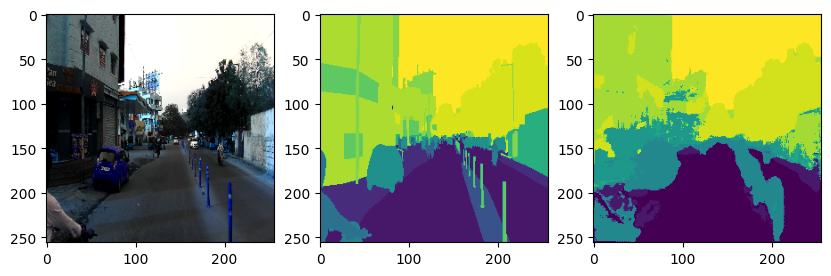

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 01: #TP=  8067, #FP=  1885, #FN= 1202, IoU=0.723
class 02: #TP=    48, #FP=   406, #FN=   57, IoU=0.094
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=     0, #FP=   113, #FN=   10, IoU=0.000
class 05: #TP=     0, #FP=     4, #FN=  129, IoU=0.000
class 06: #TP=     8, #FP=   171, #FN=   72, IoU=0.032
class 07: #TP=    13, #FP=   350, #FN=   46, IoU=0.032
class 08: #TP= 12285, #FP=  2610, #FN= 8735, IoU=0.520
class 09: #TP=  1140, #FP=  5529, #FN= 5440, IoU=0.094
class 10: #TP=    78, #FP=   312, #FN=  229, IoU=0.126
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=    12, #FP=     4, #FN=  516, IoU=0.023
class 13: #TP=    43, #FP=   291, #FN= 1141, IoU=0.029
class 14: #TP=   535, #FP=  5623, #FN=  248, IoU=0.084
class 15: #TP=  8518, #FP=  3572, #FN= 2786, IoU=0.573
class 16: #TP= 13645, #FP=   274, #FN=  533, IoU=0.944


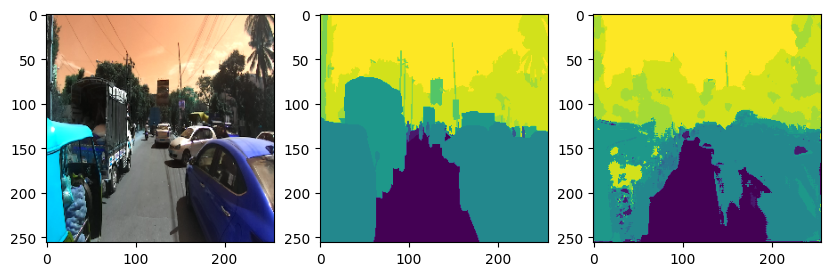

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=   17, IoU=0.000
class 01: #TP= 16955, #FP=  2373, #FN= 1406, IoU=0.818
class 02: #TP=   130, #FP=   718, #FN= 1932, IoU=0.047
class 03: #TP=     0, #FP=     0, #FN=  589, IoU=0.000
class 04: #TP=    46, #FP=    18, #FN= 1363, IoU=0.032
class 05: #TP=     0, #FP=     0, #FN= 1235, IoU=0.000
class 06: #TP=     1, #FP=    58, #FN=  261, IoU=0.003
class 07: #TP=     0, #FP=    92, #FN=  592, IoU=0.000
class 08: #TP=  4257, #FP=  3532, #FN= 2764, IoU=0.403
class 09: #TP=    66, #FP=  4205, #FN=   71, IoU=0.015
class 10: #TP=    33, #FP=   758, #FN= 2196, IoU=0.011
class 11: #TP=     0, #FP=     0, #FN=   60, IoU=0.000
class 12: #TP=     0, #FP=    18, #FN= 2490, IoU=0.000
class 13: #TP=    91, #FP=   355, #FN= 3752, IoU=0.022
class 14: #TP=  2002, #FP=  3743, #FN= 1782, IoU=0.266
class 15: #TP= 15981, #FP=  6260, #FN= 1408, IoU=0.676
class 16: #TP=  3640, #FP=   204, #FN=  416, IoU=0.854


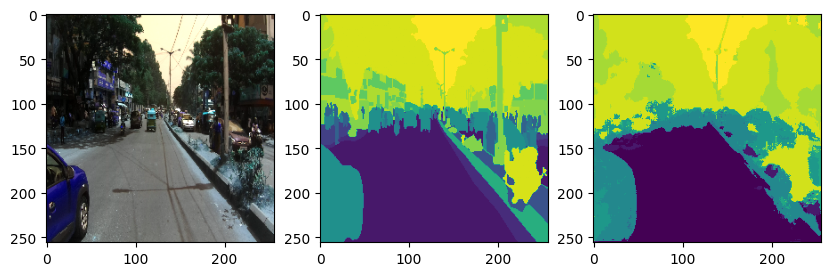

1/1 [==============================] - 3s 3s/step
class 00: #TP=     0, #FP=     0, #FN=    3, IoU=0.000
class 01: #TP= 25920, #FP=   625, #FN=  595, IoU=0.955
class 02: #TP=    90, #FP=   172, #FN=  410, IoU=0.134
class 03: #TP=     0, #FP=     0, #FN=  560, IoU=0.000
class 04: #TP=     0, #FP=    16, #FN=    0, IoU=0.000
class 05: #TP=     0, #FP=     0, #FN=   48, IoU=0.000
class 06: #TP=     0, #FP=    27, #FN=  120, IoU=0.000
class 07: #TP=     0, #FP=    21, #FN=   85, IoU=0.000
class 08: #TP=  4557, #FP=  1516, #FN= 3417, IoU=0.480
class 09: #TP=   303, #FP=  4320, #FN=  391, IoU=0.060
class 10: #TP=    26, #FP=   782, #FN= 1293, IoU=0.012
class 11: #TP=     0, #FP=     0, #FN= 2154, IoU=0.000
class 12: #TP=     0, #FP=     0, #FN=    9, IoU=0.000
class 13: #TP=     2, #FP=    92, #FN=  613, IoU=0.003
class 14: #TP=     2, #FP=  2515, #FN=   64, IoU=0.001
class 15: #TP= 23402, #FP=  1145, #FN= 1357, IoU=0.903
class 16: #TP=     3, #FP=     0, #FN=  112, IoU=0.026


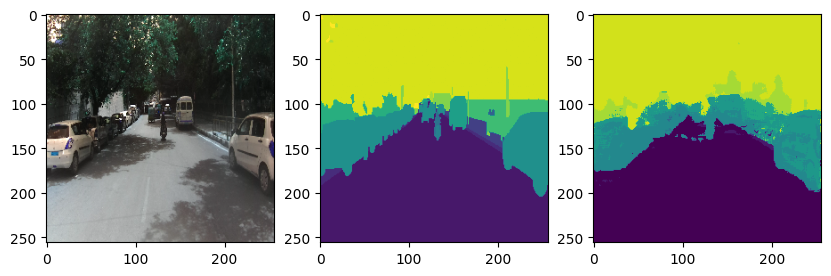

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=   46, IoU=0.000
class 01: #TP= 17791, #FP=   627, #FN= 1321, IoU=0.901
class 02: #TP=   109, #FP=   167, #FN=  461, IoU=0.148
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=     0, #FP=    10, #FN=    0, IoU=0.000
class 05: #TP=     0, #FP=     8, #FN= 4184, IoU=0.000
class 06: #TP=     0, #FP=   140, #FN=    0, IoU=0.000
class 07: #TP=    67, #FP=   220, #FN= 1773, IoU=0.033
class 08: #TP=  3839, #FP=  8400, #FN= 1370, IoU=0.282
class 09: #TP=  2635, #FP=  2698, #FN= 7210, IoU=0.210
class 10: #TP=    60, #FP=   425, #FN=  498, IoU=0.061
class 11: #TP=     0, #FP=     0, #FN=  126, IoU=0.000
class 12: #TP=    20, #FP=    75, #FN=  922, IoU=0.020
class 13: #TP=    20, #FP=   427, #FN= 1525, IoU=0.010
class 14: #TP= 16231, #FP=  5261, #FN= 2889, IoU=0.666
class 15: #TP=   908, #FP=  3539, #FN=   53, IoU=0.202
class 16: #TP=  1368, #FP=   491, #FN=  110, IoU=0.695


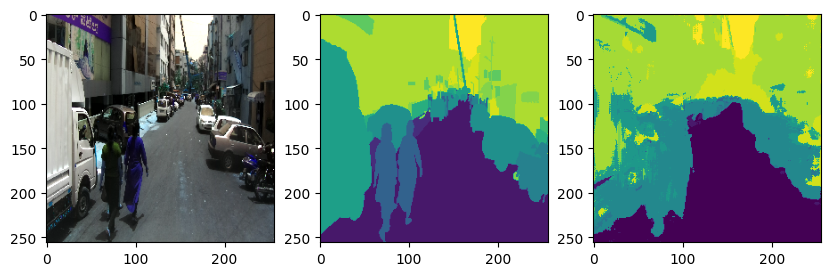

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=    5, IoU=0.000
class 01: #TP= 22378, #FP=  2034, #FN= 1284, IoU=0.871
class 02: #TP=   232, #FP=   374, #FN= 1773, IoU=0.098
class 03: #TP=     0, #FP=     0, #FN=  291, IoU=0.000
class 04: #TP=     0, #FP=     3, #FN=   44, IoU=0.000
class 05: #TP=     0, #FP=     1, #FN=  789, IoU=0.000
class 06: #TP=     6, #FP=    22, #FN= 1193, IoU=0.005
class 07: #TP=    15, #FP=    34, #FN= 1966, IoU=0.007
class 08: #TP=   163, #FP=  4406, #FN=  279, IoU=0.034
class 09: #TP=   396, #FP=  1464, #FN= 3195, IoU=0.078
class 10: #TP=     0, #FP=   318, #FN=   79, IoU=0.000
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=     0, #FP=     0, #FN=  291, IoU=0.000
class 13: #TP=    30, #FP=   136, #FN= 1546, IoU=0.018
class 14: #TP=  3428, #FP=  2328, #FN= 1675, IoU=0.461
class 15: #TP= 18399, #FP=  4344, #FN=  908, IoU=0.778
class 16: #TP=  4335, #FP=   690, #FN=  836, IoU=0.740


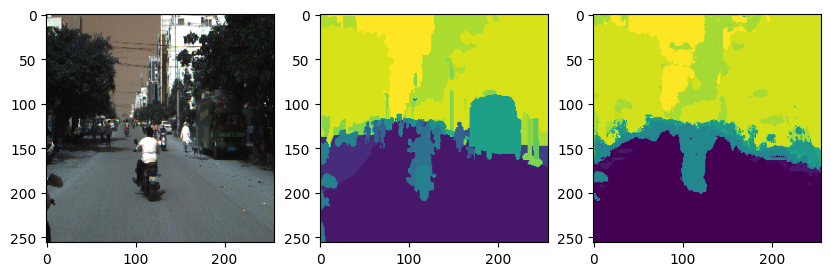

1/1 [==============================] - 3s 3s/step
class 00: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 01: #TP= 16003, #FP=  3819, #FN=  889, IoU=0.773
class 02: #TP=   215, #FP=   143, #FN= 5513, IoU=0.037
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=    31, #FP=    95, #FN= 1078, IoU=0.026
class 05: #TP=     0, #FP=     3, #FN=   51, IoU=0.000
class 06: #TP=     0, #FP=     7, #FN=    7, IoU=0.000
class 07: #TP=     0, #FP=   102, #FN=   31, IoU=0.000
class 08: #TP=  1517, #FP=  3848, #FN= 1032, IoU=0.237
class 09: #TP=    72, #FP=  2108, #FN=  108, IoU=0.031
class 10: #TP=    56, #FP=   420, #FN= 1134, IoU=0.035
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=     0, #FP=     0, #FN=  356, IoU=0.000
class 13: #TP=    47, #FP=   138, #FN= 1352, IoU=0.031
class 14: #TP=  3253, #FP=  1413, #FN= 2991, IoU=0.425
class 15: #TP= 19795, #FP=  4269, #FN= 1535, IoU=0.773
class 16: #TP=  8124, #FP=    58, #FN=  346, IoU=0.953


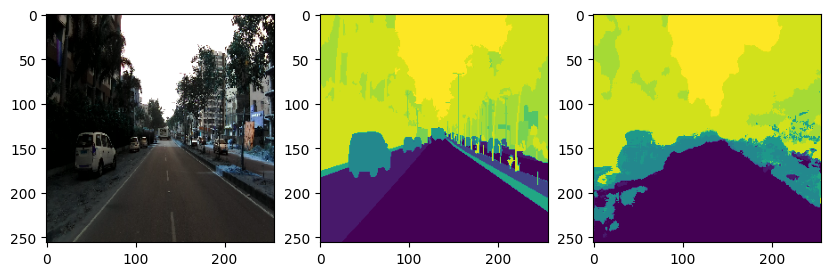

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=   47, IoU=0.000
class 01: #TP=  8960, #FP=  1179, #FN=  909, IoU=0.811
class 02: #TP=    44, #FP=    75, #FN=  215, IoU=0.132
class 03: #TP=     0, #FP=     0, #FN= 2720, IoU=0.000
class 04: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 05: #TP=     0, #FP=     2, #FN=  191, IoU=0.000
class 06: #TP=     0, #FP=     6, #FN=  789, IoU=0.000
class 07: #TP=     0, #FP=     0, #FN=  968, IoU=0.000
class 08: #TP=  3861, #FP=  3819, #FN= 2905, IoU=0.365
class 09: #TP=     0, #FP=  3390, #FN=    0, IoU=0.000
class 10: #TP=     3, #FP=   461, #FN= 1083, IoU=0.002
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=     0, #FP=    25, #FN=   96, IoU=0.000
class 13: #TP=    16, #FP=    86, #FN= 1167, IoU=0.013
class 14: #TP=     0, #FP=  5891, #FN=    0, IoU=0.000
class 15: #TP= 23333, #FP=  1544, #FN= 5392, IoU=0.771
class 16: #TP= 12627, #FP=   214, #FN=  210, IoU=0.968


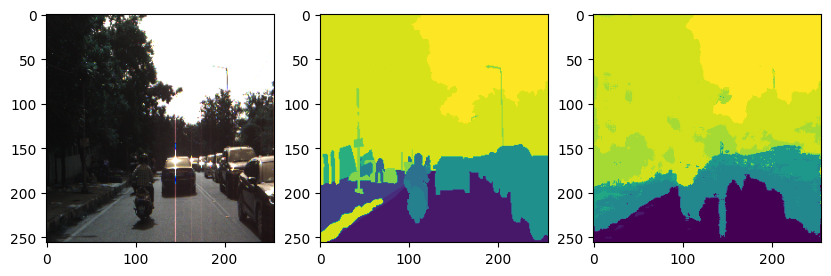

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=    4, IoU=0.000
class 01: #TP= 23345, #FP=   985, #FN=  304, IoU=0.948
class 02: #TP=     0, #FP=   433, #FN=    0, IoU=0.000
class 03: #TP=     0, #FP=     0, #FN=  646, IoU=0.000
class 04: #TP=     4, #FP=    15, #FN=  570, IoU=0.007
class 05: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 06: #TP=     3, #FP=     4, #FN=  112, IoU=0.025
class 07: #TP=     5, #FP=    28, #FN=   49, IoU=0.061
class 08: #TP=  2277, #FP=   489, #FN= 1880, IoU=0.490
class 09: #TP=     0, #FP=  1532, #FN=    4, IoU=0.000
class 10: #TP=     0, #FP=   748, #FN=    0, IoU=0.000
class 11: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 12: #TP=     0, #FP=     2, #FN=  593, IoU=0.000
class 13: #TP=    10, #FP=    59, #FN= 1678, IoU=0.006
class 14: #TP=     3, #FP=  1595, #FN=   12, IoU=0.002
class 15: #TP= 11290, #FP=  1628, #FN= 1673, IoU=0.774
class 16: #TP= 20758, #FP=   323, #FN=  316, IoU=0.970


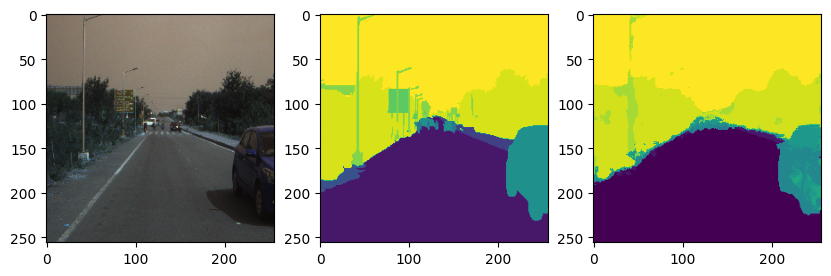

1/1 [==============================] - 2s 2s/step
class 00: #TP=     0, #FP=     0, #FN=    2, IoU=0.000
class 01: #TP= 11029, #FP=   604, #FN=  516, IoU=0.908
class 02: #TP=  2502, #FP=   114, #FN= 1698, IoU=0.580
class 03: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 04: #TP=     0, #FP=   343, #FN=    0, IoU=0.000
class 05: #TP=     0, #FP=     0, #FN=    0, IoU=0.000
class 06: #TP=     0, #FP=     1, #FN=    0, IoU=0.000
class 07: #TP=     0, #FP=    20, #FN=    0, IoU=0.000
class 08: #TP=  3704, #FP=   735, #FN= 4252, IoU=0.426
class 09: #TP=     0, #FP=  5015, #FN=    0, IoU=0.000
class 10: #TP=     0, #FP=  1229, #FN=    0, IoU=0.000
class 11: #TP=     0, #FP=     6, #FN= 1372, IoU=0.000
class 12: #TP=     6, #FP=     5, #FN=  378, IoU=0.015
class 13: #TP=   149, #FP=   194, #FN= 9844, IoU=0.015
class 14: #TP=  3380, #FP=  7993, #FN=  832, IoU=0.277
class 15: #TP= 13238, #FP=  5267, #FN= 1666, IoU=0.656
class 16: #TP=  9586, #FP=   416, #FN= 1382, IoU=0.842


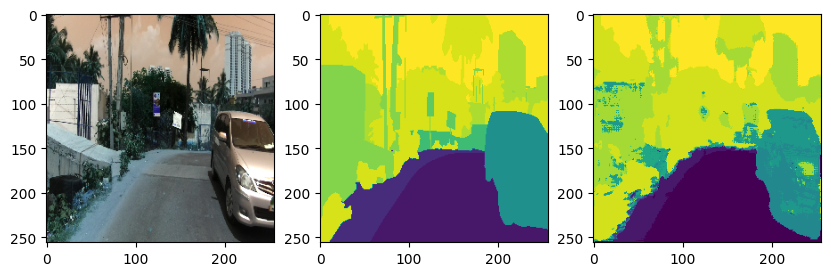

In [58]:
a=0
ious= []
for i in range(len(x_test)):

    a+=1
    iou_im=[]

    #original image
    image = cv2.imread(list(x_test['image'])[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256),interpolation = cv2.INTER_NEAREST)

    #predicted segmentation map
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    pred_mask = tf.argmax(pred_mask, axis=-1)


    #original segmentation map
    image_mask = cv2.imread(list(x_test['mask'])[i], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)
    image_mask=image_mask//10

    for c in range(17):
      TP = np.sum((image_mask == c) & (pred_mask == c))
      FP = np.sum((image_mask != c) & (pred_mask == c))
      FN = np.sum((image_mask == c) & (pred_mask != c))

      if TP + FP + FN == 0:
        iou=0
      else:
        iou = TP / float(TP + FP + FN)
      iou_im.append(iou)
      print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,iou))
    ious.append(iou_im)



    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(pred_mask[0])
    plt.show()
    if a==20:
      break

In [59]:
arr=np.array(ious)


In [61]:
miou = np.mean(ious, axis=0)
for i in range(17):
  print(str(i) + '\t' + str(miou[i]) + '\n')


0	0.0

1	0.854958479376814

2	0.14235722632348463

3	0.0

4	0.006718200831179209

5	0.0

6	0.011959043745724167

7	0.038556642670154205

8	0.27079525504225527

9	0.06561078142233868

10	0.04766009890549609

11	0.0

12	0.0033453091092979495

13	0.02016963040418763

14	0.20448713779178118

15	0.6799083368562563

16	0.8314853501424843



higher mious for 1 (road), 8 (car) ,15(vegetation) ,16(sky), 14(buildings) indicating model is more successful in segmenting these classes






In [ ]:
import cv2
import os

SAVE_PATH = os.path.join(os.getcwd(),'drive','MyDrive')
# Read the video from specified path
cam = cv2.VideoCapture(os.path.join(SAVE_PATH,'VIDEO.mp4'))

try:

	# creating a folder named data
	if not os.path.exists('video'):
		os.makedirs('video')

# if not created then raise error
except OSError:
	print ('Error: Creating directory of video')

# frame
currentframe = 0

while(True):

	# reading from frame
    ret,frame = cam.read()

    if ret:
        # if video is still left continue creating images
        name = os.path.join(os.getcwd(),'video','frame' + str(currentframe) + '.jpg')
        #name = './data/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name)

        # writing the extracted images
        cv2.imwrite(name, frame)

        # increasing counter so that it will
        # show how many frames are created
        currentframe += 1
    else:
      break

# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

Streaming output truncated to the last 5000 lines.
Creating.../content/video/frame140.jpg
Creating.../content/video/frame141.jpg
Creating.../content/video/frame142.jpg
Creating.../content/video/frame143.jpg
Creating.../content/video/frame144.jpg
Creating.../content/video/frame145.jpg
Creating.../content/video/frame146.jpg
Creating.../content/video/frame147.jpg
Creating.../content/video/frame148.jpg
Creating.../content/video/frame149.jpg
Creating.../content/video/frame150.jpg
Creating.../content/video/frame151.jpg
Creating.../content/video/frame152.jpg
Creating.../content/video/frame153.jpg
Creating.../content/video/frame154.jpg
Creating.../content/video/frame155.jpg
Creating.../content/video/frame156.jpg
Creating.../content/video/frame157.jpg
Creating.../content/video/frame158.jpg
Creating.../content/video/frame159.jpg
Creating.../content/video/frame160.jpg
Creating.../content/video/frame161.jpg
Creating.../content/video/frame162.jpg
Creating.../content/video/frame163.jpg
Creating.../c

In [ ]:
'''Creating and saving our masks which the model predicted for the video'''
i=0
if(not os.path.exists(os.path.join(os.getcwd(),'drive','MyDrive','video_mask3'))):
  os.mkdir(os.path.join(os.getcwd(),'drive','MyDrive','video_mask3'))

frames = len(os.listdir(os.path.join(os.getcwd(),'video')))
frames

#iterating over all the video frames
while(i!=frames):

  #Getting the image abd resizing it according to our input model
  image_path = os.path.join(os.getcwd(),'video','frame'+str(i)+'.jpg')
  image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  #getting the prediction mask image
  prediction = model.predict(image[np.newaxis,:,:,:])
  prediction = tf.argmax(prediction,axis=-1)
  prediction = tf.expand_dims(prediction,axis=-1)

  #saving the mask image
  plt.figure(figsize=(10,6))
  plt.subplot(132)
  plt.imshow(prediction[0,:,:,0])
  mask_path = os.path.join(os.getcwd(),'drive','MyDrive','video_mask3','frame'+str(i)+'.png')
  print('Creating...',mask_path)
  plt.savefig(mask_path)
  plt.close()
  i+=1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Creating... /content/drive/MyDrive/video_mask3/frame2640.png
1/1 [==============================] - 0s 22ms/step
Creating... /content/drive/MyDrive/video_mask3/frame2641.png
1/1 [==============================] - 0s 21ms/step
Creating... /content/drive/MyDrive/video_mask3/frame2642.png
1/1 [==============================] - 0s 21ms/step
Creating... /content/drive/MyDrive/video_mask3/frame2643.png
1/1 [==============================] - 0s 21ms/step
Creating... /content/drive/MyDrive/video_mask3/frame2644.png
1/1 [==============================] - 0s 21ms/step
Creating... /content/drive/MyDrive/video_mask3/frame2645.png
1/1 [==============================] - 0s 21ms/step
Creating... /content/drive/MyDrive/video_mask3/frame2646.png
1/1 [==============================] - 0s 21ms/step
Creating... /content/drive/MyDrive/video_mask3/frame2647.png
1/1 [==============================] - 0s 21m